# Распознавание лиц при помощи SVM
В этот раз мы попытаемся распознавать найденные лица. С прошлого раза в папке classes должны иметься фотографии лиц. Давайте разложим их по подпапкам: фото каждого человека в подпапку с именем этого человека. Получится, файлы у нас будут

 `../classes/petya/0001.JPG`, `../classes/petya/0002.JPG`, ... `../classes/vasya/0101.JPG` и т.п.
 
Распознавать лица будем не самым передовым, зато очень простым методом: *методом опорных векторов*. Его реализация имеется в пакете scikit-learn:

    pip install scikit-learn
    python
    >>> import sklearn

Распознавание будет состоять из двух этапов. 

1. Все наши фотографии можно превратить в векторы, просто выписав в одну строку значения яркости на всех пикселах (изображение черно-белое, цвет каждого пиксель задается целым числом от 0 до 255). Например, изображения 160x160 будут представлены вектором длины 25600. Однако такие векторы - не очень хорошая форма входных данные для распознавания, например, даже сдвинуть в графическом редакторе изображение лица всего лишь на один пиксель влево-вверх, мы получим совершенно другой вектор, с разницей по всем координатам, хотя лицо осталось то же. Эту проблему можно облегчить, воспользовавшись методом главных компонент, который выделяет небольшой ортонормальный базис в пространстве той самой огромной размерности, например, базис из 150 векторов в пространстве размерности 25600. Желательно, чтобы, например, те же самые сдвиги оказывались перепендикулярны пространству главных компонент, тогда при проекции две картинки, отличающиеся лишь сдвигом, спроектируются в один и тот же вектор. В sklearn за метод главных компонент отвечает модуль `PCA` (`RandomizedPCA` в версиях до 0.20)

2. Узнав пространство главных компонент, мы спроектируем на него все наши картинки. На полученных векторах из 150 координат и будем обучать метод опорных векторов. В sklearn этим занимается `SVM`. Перебором всех сочетаний параметров находится комбинация, обеспечивающая наилучшую точность на тестовой выборке.

Код немножко отличается для версий младше 0.20 и для последующих. Вообще, авторы sklearn постоянно прибираются, и поэтому функции иногда переезжают из модуля в модуль. Для примера можно прогнать код, который распознает фотографии знаменитостей из набора LFW: Labeled Faces in the Wild. Ниже приведен откомментированный код из [примера в документации scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html):

## Импорты и получение данных LFW

In [1]:
from __future__ import print_function
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Загружаем данные датасета LFW, как набор NumPу-массивов
# ограничиваемся людьми, имеющими минимум 70 фото в базе
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# Получится объект типа Bunch, напоминающий словарь, со свойствами  
# 'data', 'images', 'target', 'target_names', 'DESCR'

# выясним число фото, их размеры (одинаковые для всех фото)
n_samples, h, w = lfw_people.images.shape
print("Размер фото %d x %d" % (h, w))

# свойство data содержит все изображения в виде матрицы n_samples x число пикселей в фото
X = lfw_people.data
n_features = X.shape[1]

# свойство target содержит ответ - номер личности,
# а target-names - список имен для всех личностей
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Размеры датасета:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Размер фото 50 x 37
Размеры датасета:
n_samples: 1288
n_features: 1850
n_classes: 7


`n_samples` – общее число фото в датасете, `n_features` – длина исходного вектора, то есть число пикселей `h`×`w` в фото, `n_classes` – число людей в датасете. Код в клетках ниже нуждается только в `X`, `y`, `h`, `w` и `target_names`, то есть когда мы заготовим наши данные в виде матрицы NumPy X и вектора ответов y, можно будет просто заново выполнить эти клеточки.

## Разбивка на обучающую и тестовую выборки, обучение МГК

In [2]:
# #############################################################################
# Разбиваем данные на обучающую и тестовую выборку, оставляя на тест четверть данных,
# при этом пропорция соблюдается не только на всем датасете, но и на каждом классе 
# в отдельности (stratified)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# #############################################################################
# Теперь выделяем главные компоненты, снижая размерность до n_components
# При этом выделяемые векторв (называемые собственными лицами, eigenfaces),
# находятся только по X, то есть y не используется, метод - без учителя
n_components = 150

print("Выделяем %d главных компонент (собственных лиц) на %d лицах из обучающей выборки"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("Сделано за %0.3fс" % (time() - t0))

print("Проектируем входные данные - векторы размера %d - на найденный ортонормальный базис" % X_train.shape[1])
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Сделано за %0.3fс" % (time() - t0))

print("Получено %d векторов длины %d" % X_train_pca.shape)

Выделяем 150 главных компонент (собственных лиц) на 966 лицах из обучающей выборки
Сделано за 0.183с
Проектируем входные данные - векторы размера 1850 - на найденный ортонормальный базис
Сделано за 0.022с
Получено 966 векторов длины 150


## Обучение классификатора на основе МОВ

In [3]:
# #############################################################################
# обучаем классификатор на основе метода опорных векторов
print("Обучение...")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("Сделано за %0.3fс" % (time() - t0))
print("Лучший найденный классификатор:")
print(clf.best_estimator_)

Обучение...
Сделано за 47.446с
Лучший найденный классификатор:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Проверка на тестовом наборе
Когда классификатор обучен, надо проверить его на данных, которые не использовались в обучении, то есть на тестовой выборке. Мы запускаем метод `predict` созданного в предыдущей клетке объекта `clf` (классификатора) на тестовыой выборке, а точнее на ее проекции на 150-мерное пространство главных компонент. Встроенные методы `classification_report` и `confusion_matrix` позволяют при небольшом объеме классов довольно наглядно понять ситуацию. 

classification_report показывает такие метрики:

* *точность* (presision) – доля среди всех фото, так названных классификатором, верно названных фотографий данного человека
* *полнота* (recall) – доля среди всех фото этого человека, фотографий правильно названных классификатором
* *f1-мера* – среднее гармоническое точности и полноты
* *support* – общее число фото этого человека в тестовом наборе

Средние подсчитываются либо по классам (micro), либо по штукам (macro) либо с коэффициентами, отражающими относительную величину каждого класса (weighted).

В матрице ошибок `confusion_matrix` по горизонтали идут настоящие классы, а по вертикали – классы, названные классификатором. Таким образом, для каждого класса точность – это диагональный элемент, деленный на сумму элементов соответствующего столбца, а полнота – это диагональный элемент, деленный на сумму элементов соответствующей строки.

In [4]:
print("Получаю ответы классификатора на тестовом множестве...")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Сделано за %0.3fс" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Получаю ответы классификатора на тестовом множестве...
Сделано за 0.068с
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.46      0.55        13
     Colin Powell       0.83      0.87      0.85        60
  Donald Rumsfeld       0.86      0.67      0.75        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

        micro avg       0.85      0.85      0.85       322
        macro avg       0.87      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  1  52   2   5   0   0   0]
 [  1   1  18   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   3   1   8   0]
 [  1   1   1   6   0   0  27]]


## Некоторые ошибочно распознанные лица

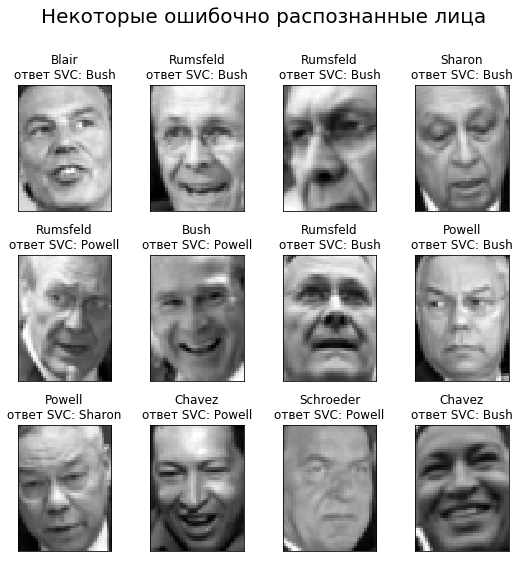

In [5]:
def plot_wrong_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.suptitle("Некоторые ошибочно распознанные лица\n ", y=1.05, size=20)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

wrong_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
X_wrong = [X_test[i] for i in wrong_indices]
wrong_name = [target_names[y_pred[i]].split(' ')[-1] for i in wrong_indices]
right_name = [target_names[y_test[i]].split(' ')[-1] for i in wrong_indices]
prediction_titles = ["%s\nответ SVC: %s" % (real, wrong_name[i]) for i, real in enumerate(right_name)]
        
plot_wrong_gallery(X_wrong, prediction_titles, h, w)

plt.show()

## Задание 1
Обучите классификатор на классах из папки `../classes/` и получите отчет о классификации, матрицу ошибок, и галерею неверно распознанны лиц для своих фото.

#### Подсказки
Ниже приведено получение списка всех .jpg-фото из подпапок папоки classes

In [ ]:
import glob
pic_fns = glob.glob('../classes/**/*.jpg')
pic_fns

Для того, чтобы код обучения и оценки классификатора заработал, нам надо изготовить матрицу `X`, в строках которой будут записаны пиксели наших картинок, вектор `y`, содержащий для каждой картинки номер класса, а также массив строковых названий классов `target_names` и размеры фотографий `h`, `w`. Строки будут именами подпапок:

In [6]:
import os
fn = '../classes/petya/0001.JPG'
name = fn.split(os.path.sep)[-2]
name

'petya'

Для примера зачитаем изображение `chavez.jpg` из текущей папки и поместим его второй строкой (считая с нуля) в нулевую матрицу из пяти строк такого размера:

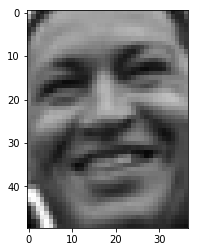

In [7]:
import cv2, numpy as np
img = cv2.imread('chavez.jpg', cv2.IMREAD_GRAYSCALE)
h, w = img.shape
X = np.zeros((5, h*w), dtype='uint8')
X[2] = img.flatten()
plt.imshow(X[2].reshape(h,w), cmap=plt.cm.gray)